In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.rcParams['axes.unicode_minus'] = False

def load_data(test_rate=0.2):
    # 1.从文件导入数据
    data_file = r"boston_house_prices.csv"
    with open(data_file, encoding='utf-8') as f:
        data = np.loadtxt(data_file, delimiter=',', skiprows=2)
    X = data[:, :-1]
    y = data[:, -1]

    # 随机打乱数据
    np.random.seed(42)  # 使用相同的随机种子，保证每次运行得到相同的结果
    shuffle_indices = np.random.permutation(len(X)) # 生成随机序列
    X, y = X[shuffle_indices], y[shuffle_indices]   # 用随机序列对数据进行重排
    
    # 2.将原数据集拆分成训练集和测试集，按照test_rate划分
    num_test = int(len(X) * test_rate)
    X_test, y_test = X[:num_test], y[:num_test]
    X_train, y_train = X[num_test:], y[num_test:]
    # 3、返回训练和测试数据集的特征和标签
    return X_train, y_train, X_test, y_test 


def data_processing(train_data, test_data, kind=1):
    # 1、传入train_data,test_data以及选择那一种归一化的kind 参数
    train_std = np.zeros_like(train_data, dtype=float)  # 生成一个和train_data维度相同的全0数组
    test_std = np.zeros_like(test_data, dtype=float)    
    
    # 当kind=1时，进行z-score标准化处理；当kind=2时，进行最大最小归一化处理
    if kind==1:
        avg = np.mean(train_data, axis=0)   # 均值
        std = np.std(train_data, axis=0)    # 标准差
        train_std = (train_data - avg) / std
        test_std = (test_data - avg) / std
    # 3.最大最小归一化处理
    else:
        max = np.max(train_data, axis=0)
        min = np.min(train_data, axis=0)
        train_std = (train_data - min)/(max - min)
        test_std = (test_data - min)/(max - min)

    # 返回处理后的数据集
    return train_std, test_std

    
def get_batches(dataset, labels, batch_size=1, drop_last=False):    # 将数据集划分为多个批次，每个批次的样本数量为 batch_size
    # drop_last：是否丢弃最后一个不足batch_size的批次
    batches = []
    index = 0
    data_len = dataset.shape[0]
    if drop_last:
        data_len -= data_len % batch_size

    while index < data_len:
        # 如果数据集的长度大于等于index+batch_size，则取出index到index+batch_size的数据
        if index + batch_size < data_len:
            x = dataset[index:index + batch_size]
            y = labels[index:index + batch_size]
        elif not drop_last:
            x = dataset[index:]
            y = labels[index:]
        index += batch_size
        batches.append([x, y])
    
    # 返回划分好的批次,其中包含了批次数据集的的特征和标签
    return batches


class LinearRegression_numpy(object):
    def __init__(self, num_of_weights):
        # 初始化系数w的值，利用随机数生成函数生成服从标准正态分布的随机数
        # 这里是将截距 b并入了系数w中，所以系数w的长度比特征数多1
        self.w = np.random.randn(num_of_weights + 1)    
        

    # 将预测输出的过程以“类和对象”描述
    def forward(self, X):
        # y_pred = np.dot(X, self.w)  # 矩阵乘法
        # 这个函数的作用是将X和self.w进行矩阵乘法运算，得到y_pred
        return np.dot(X, self.w[1:]) + self.w[0]    
        

    def loss(self, X, y):
        # 这个函数的作用是计算模型在数据集X上的均方误差
        y_pred = self.forward(X)            # 调用forward函数，得到预测值
        return np.mean((y - y_pred)**2)

    def gradient(self, X, y):
        # 这个函数的作用是计算模型在数据集X上的梯度
        y_pred = self.forward(X)            # 调用forward函数，得到预测值
        grad_w = -2/len(X) * np.dot(X.T, (y - y_pred))  # 根据公式计算梯度，这里是对w求导
        grad_b = -2/len(X) * np.sum(y - y_pred)     # 根据公式计算梯度，这里是对b求导
        return grad_w, grad_b

    
    def update(self, grad_w, grad_b, eta):
        # 这个函数的作用是根据梯度和学习率更新系数w（包含截距）
        self.w[1:] -= eta * grad_w  # 根据梯度和学习率更新系数w
        self.w[0] -= eta * grad_b   # 根据梯度和学习率更新截距b

    
    def train_BGD(self, X, y, num_epoches, eta):
        # 这个函数的作用是使用梯度下降法训练模型
        loss_history = [] # 用于保存每次迭代后的损失函数值
        for epoch_id in range(num_epoches): # 开始迭代，迭代周期是num_epoches，每次迭代都要计算当前的梯度，并更新参数
            grad_w, grad_b = self.gradient(X, y)    # 计算梯度，计算当前参数下损失函数的梯度
            self.update(grad_w, grad_b, eta)        # 更新参数
            loss = self.loss(X, y)
            loss_history.append(loss)               # 计算损失函数的值，保存到loss_history中
        return loss_history
    def train_MBGD(self, X, y, num_epoches, batch_size, eta, drop_last=False):
        loss_history = []           # 用于保存每次迭代后的损失函数值
        np.random.seed(54)          # 设置随机种子，保证每次运行结果一致
        for epoch_id in range(num_epoches):
            # for X, y in get_batches(X, y, batch_size, drop_last=drop_last):
                # 经典的四步训练流程：前向计算->计算损失->计算梯度->更新参数（分别调用类的方法）
                indices = np.random.choice(len(X), batch_size)  # 随机采样batch_size个样本，返回采样样本的下标
                X_batch, y_batch = X[indices], y[indices]       # 根据下标取出对应的样本

                loss = self.loss(X_batch, y_batch)              # 计算损失函数值，保存到loss_history中
                loss_history.append(loss)
                grad_w, grad_b = self.gradient(X_batch, y_batch)# 计算当前参数下损失函数的梯度
                self.update(grad_w, grad_b, eta)                # 更新参数
                
        return loss_history
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['font.size'] = 11

### 调用定义的方法和类

BGD 训练耗时 0.0361783504486084 s


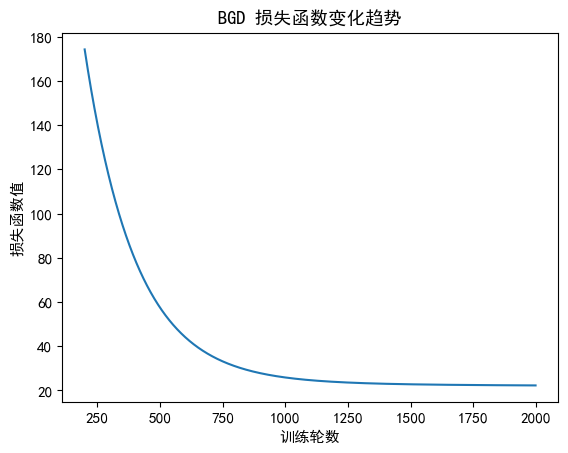

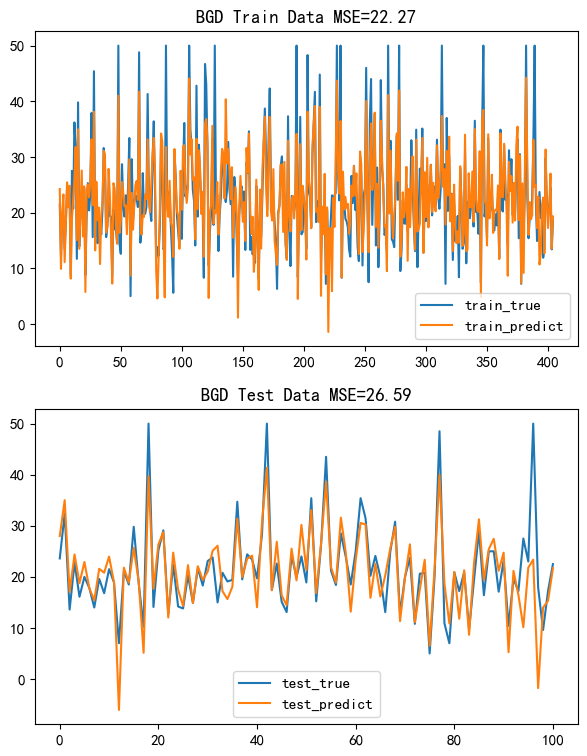

In [2]:
num_epoches = 2000 # 训练轮数

lr = 0.001234        # 学习率，BGD 和 MBGD 的学习率都采用这个值

# 1、获取数据并划分数据集
X_train, y_train, X_test, y_test = load_data(test_rate=0.2)
# 2、数据标准化/归一化处理
# data_processing(X_train, X_test)
X_train, X_test = data_processing(X_train, X_test, 1)

# 3、LinearRegression_numpy 类实例化
reg_bgd = LinearRegression_numpy(X_train.shape[1])# 调用类中自定义的 train_BGD()，训练模型
start = time.time()

losses_bgd = reg_bgd.train_BGD(X_train, y_train, num_epoches=num_epoches, eta=lr)   
print("BGD 训练耗时",time.time()-start,"s")

# 4、使用测试集进行测试，模型评价
# 将模型训练得到的系数w与测试数据test_data计算得到预测值。
# 计算测试集的MSE
MSE_bgd = reg_bgd.loss(X_test, y_test)
# 5、画出损失函数的变化趋势，画出预测值与真实值曲线
plt.figure()
plt.plot(np.arange(int(num_epoches / 10),num_epoches), losses_bgd[int(num_epoches / 10):])  # 只绘制后 90% 的训练轮数，都绘制的话趋势变化可视化效果不好
plt.xlabel("训练轮数")
plt.ylabel("损失函数值")
plt.title("BGD 损失函数变化趋势")
# plt.show()

# 测试集
plt.figure(figsize=(7,9))
plt.subplot(212)
plt.plot(y_test,label='test_true')
plt.plot(reg_bgd.forward(X_test),label='test_predict')
plt.title("BGD Test Data MSE={:.2f}".format(MSE_bgd))
# plt.show()
plt.legend() # 添加图例

# 训练集
MSE = reg_bgd.loss(X_train, y_train)
plt.subplot(211)
plt.plot(y_train,label='train_true')
plt.plot(reg_bgd.forward(X_train),label='train_predict')
plt.title("BGD Train Data MSE={:.2f}".format(MSE))
plt.legend() # 添加图例

plt.show()

MBGD 训练耗时 0.006645107269287109 s
num_epoches=2000, batch_size=40,lr=0.00100000, MSE=27.14
MBGD 训练耗时 0.006337738037109375 s
num_epoches=2000, batch_size=80,lr=0.00100000, MSE=25.65
MBGD 训练耗时 0.0068579912185668945 s
num_epoches=2000, batch_size=100,lr=0.00100000, MSE=25.21
MBGD 训练耗时 0.007177209854125977 s
num_epoches=2000, batch_size=200,lr=0.00100000, MSE=25.09


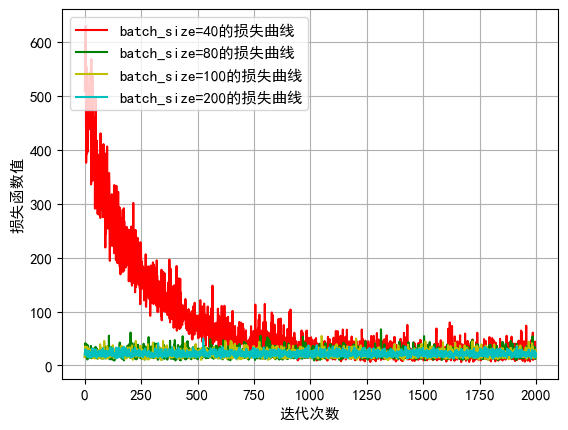

<Figure size 640x480 with 0 Axes>

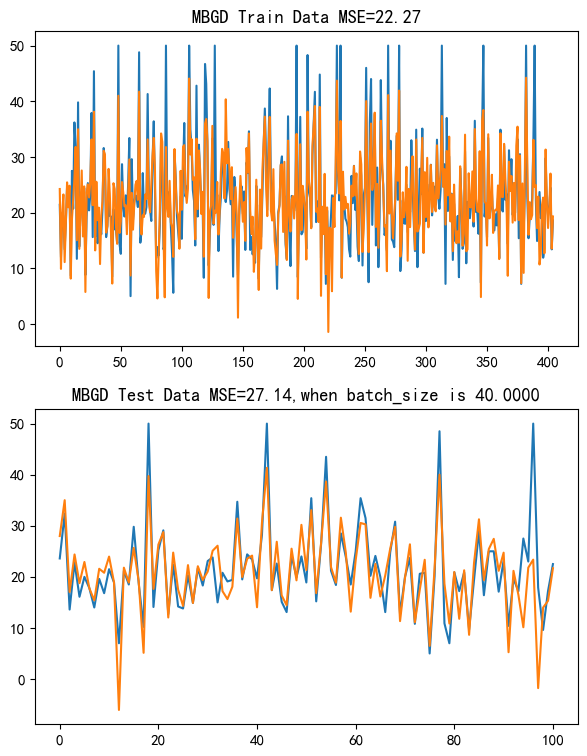

<Figure size 640x480 with 0 Axes>

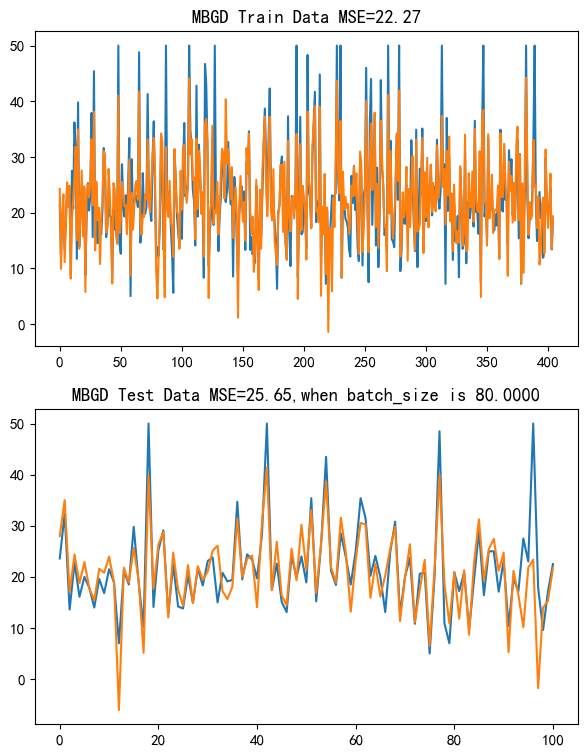

<Figure size 640x480 with 0 Axes>

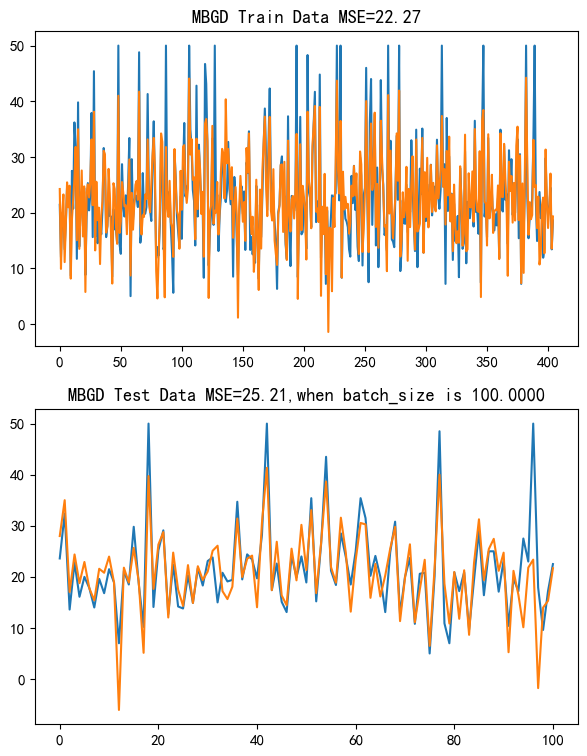

<Figure size 640x480 with 0 Axes>

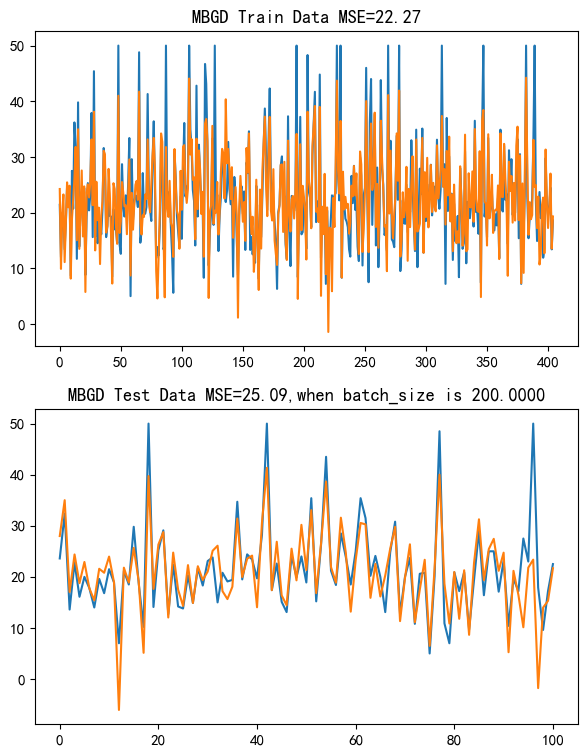

In [3]:
# 1、获取数据并划分数据集
X_train, y_train, X_test, y_test = load_data(test_rate=0.2)
# 2、数据标准化/归一化处理
# data_processing(X_train, X_test)
X_train, X_test = data_processing(X_train, X_test, 1)
reg_mbgd = LinearRegression_numpy(X_train.shape[1])
MSE_list = []

lr = 0.001        # 学习率，BGD 和 MBGD 的学习率都采用这个值
num_epoches = 2000 # 训练轮数

fig, ax1 = plt.subplots()
# fig, ax2 = plt.subplots()
ax1.grid()
ax1.set_xlabel('迭代次数')
ax1.set_ylabel('损失函数值')
for batch_size in [40,80,100,200]: 
    # 当 batch_size=len(X_train)时，等价于BGD，当batch_size=1时，等价于SGD
    num_epoches_mbgd = int(4*batch_size) # 确保对于不同的 batch_size，训练的轮数相同，因为不同的 batch_size,
                                            # 每轮的迭代次数等于样本总数/batch_size，所以通过调整 num_epoches 来保证每轮迭代次数相同
    MSE = 0
    start = time.time()
    
    
        
    losses_mbgd = reg_mbgd.train_MBGD(X_train, y_train, num_epoches=num_epoches, batch_size=batch_size, eta=lr)
    y_predict = reg_mbgd.forward(X_test)
        
    # plt.show()
    if batch_size == 20: 
        ax1.plot(losses_mbgd,  linestyle='-', color='b', label='batch_size=20 的损失曲线')
    elif batch_size == 40: 
        ax1.plot(losses_mbgd,  linestyle='-', color='r', label='batch_size={}的损失曲线'.format(40))
    elif batch_size == 80:
        ax1.plot(losses_mbgd,  linestyle='-', color='g', label='batch_size={}的损失曲线'.format(80))
    elif batch_size == 100:
        ax1.plot(losses_mbgd,  linestyle='-', color='y', label='batch_size={}的损失曲线'.format(100))
    elif batch_size == 200:
        ax1.plot(losses_mbgd,  linestyle='-', color='c', label='batch_size={}的损失曲线'.format(200))  
    ax1.legend(loc='upper left')
    losses_mbgd=[]
    plt.figure()
    plt.figure(figsize=(7,9))
    plt.subplot(212)
    plt.plot(y_test)
    plt.plot(reg_bgd.forward(X_test))
    MSE_mbgd=reg_mbgd.loss(X_test, y_test)
    plt.title("MBGD Test Data MSE={:.2f},when batch_size is {:.4f}".format(MSE_mbgd,batch_size))
    # plt.show()

    # 训练集
    MSE = reg_bgd.loss(X_train, y_train)
    plt.subplot(211)
    plt.plot(y_train)
    plt.plot(reg_bgd.forward(X_train))
    plt.title("MBGD Train Data MSE={:.2f}".format(MSE))

    print("MBGD 训练耗时",(time.time()-start)/10.0,"s")
    
    print("num_epoches={}, batch_size={},lr={:.8f}, MSE={:.2f}".format(num_epoches,batch_size,lr,reg_mbgd.loss(X_test, y_test)))

# 由图，较大的批量可以使模型对每一步的参数更新有更准确的估计，可能会使得模型在训练集上的表现更好
# 训练稳定性：较小的批量会导致训练过程中损失函数的震荡更加剧烈，而较大的批量可以使训练过程更加稳定